## 实验：信贷风险管理的Vintage分析  

### 实验目标：熟悉基础风控指标，掌握Vintage分析方法  

### 实验要求：补全代码中#TODO部分（共6处），画出Vintage曲线图

## 零、信贷风控规则的回顾  

信贷风控的本质是剔除坏客户，保留好客户。因此，类似于自来水厂过滤杂质得到纯净水，其从结果上体现就是以损失一定的流量作为代价，来换取通过流量的纯净性。  

如图1所示，信贷风控是上游的阀门，常见的指标就是通过率和逾期率。  
* **通过率**表示阀门拧得有多紧  
* **逾期率**表示通过流量有多纯净  
![Image Name](https://cdn.kesci.com/upload/s21ruycxb8.jpeg)  
图 1 - 风控规则作用前后的示意图

### 信贷系统的特点  

信贷系统在运行中具有几个特征，如下表所示。正因为信贷系统的高滞后性，在信贷风控系统中，才对决策的稳定性提出了高要求。虽然通过率是立竿见影的，但风险是严重滞后的。每一次策略调整，都有较长的风险表现周期，如果频繁调整则很难分析清楚影响。因此，信贷系统的风险控制确实是一个难题。  

| 特征 | 解释 |  
| -------- | -------- |  
| 高滞后性| 分期还款产品第一期还款日是放款后30天，才能观察到资产的首逾风险。这就存在30天的滞后。以此类推，越是关注长期风险，滞后期越长。因此，短期限信贷产品风险相对于长期限更容易控制，其风险反馈更快。 |  
| 多干扰项| 金融监管政策（业务、数据）、外部市场环境、用户客群等因素一直在发生扰动。例如：P2P行业清退、联合贷款政策、数据安全法、24定价限制等等。 |  
| 难测量性 |数据监管政策、采集原因等导致很多测量误差。例如，任何多头数据商都无法覆盖所有的金融机构，导致很多决策都只是依赖于当前可测量的数据下进行，可能并不能完全反映客户的真实情况。在小微贷款中，数据缺失现象更为严重。 |  
| 可解释性 |国外信贷监管要求决策要可透明，对拒贷规则必须要有明确的原因。这就限制了一些黑盒的机器学习、深度学习模型的使用，而会尽可能使用LR评分卡模型，便于从Reason Code上归因。 |  


### 还款监控是监控“水质”情况的重要手段，用到Vintage分析资产质量  

阀门的松紧并没有好坏之分，很多时候和企业战略有关：  
* 资方限制，资方提供的额度有限，导致上游流量不足  
* 市场扩张，为了获取更多的市场份额，需要让更多的流量通过  
* 坏账管理，为了减少贷后的坏账损失，需要减少劣质流量的通过  

但是通过流量的质量一定是越高越好，影响质量的主要原因有：  
* 过滤系统，风控算法越出色，能更精准的识别“坏客户”  
* 上游水质，上游的市场投放规则获取的客群决定了源头的水质

### 参考文章  
https://zhuanlan.zhihu.com/p/149978781  
https://zhuanlan.zhihu.com/p/81027037  
https://zhuanlan.zhihu.com/p/163206686  

## 一、基础风控指标  

### 1. 帐龄（Month on Book，MOB）  

指资产放款月份。类似于婴孩一出生就有了年龄，一旦申请贷款订单被放款，便拥有了账龄和生命周期。  

MOB0：放款日至当月月底  
MOB1：放款后第二个完整的月份  
MOB2：放款后第三个完整的月份  
MOB的最大值取决于信贷产品期限。如果是12期产品，那么该资产的生命周期是12期，MOB最大到MOB12。  

例如，2022年11月13日放款的订单，2022年11月是MOB0，2022年12月是MOB1，以此类推。  

### 2. 逾期天数（Days Past Due，DPD）  

逾期天数 = 实际还款日 - 应还款日。  

DPDN+表示逾期天数 >= N天，如DPD30+表示逾期天数 >=30天的资产  

例如，若还款日是每月8号，那么9号就是逾期第一天。如果客户在10号还款，那么逾期2天。  

### 3. 逾期期数（M）  

指实际还款日与应还款日之间的逾期天数，并按区间划分后的逾期状态。M取自Month on Book的第一个单词。  
（注：不同机构所定义的区间划分可能存在差异）  

M0：当前未逾期（或用C表示，取自Current）  
M1： 逾期1-30日  
M2：逾期31-60日  
M3：逾期61-90日  
M4：逾期91-120日  
M5：逾期121-150日  
M6：逾期151-180日  
M7：逾期180日以上。此时也被称为呆账（Bad Debts），会予以注销账户（write-off）  


## 二、什么是 Vintage 分析  
Vintage一词最初来源于葡萄酒业 。由于每年采摘的葡萄会受到日照、气温、降水等因素的影响，最终酿造的葡萄酒品质会存在差异。在窖藏一定年份后，葡萄酒的品质将趋于稳定，也就是品质成熟，这段年份数被称为成熟期（maturity）。  

简便起见，我们以酒精浓度作为衡量葡萄酒品质的标准，约定：浓度越高，品质越好。首先，记录入窖年份作为该批次葡萄酒的标签，这也被称为Vintage或者Cohort。之后，将每年定期抽样测量酒精浓度，保存记录数据，如图1所示。  

经过几年的数据积累，我们就可以绘制出酒精浓度随时间变化的Vintage曲线。俗话说，酒越酿越醇，Vintage曲线通常是单调递增的，  


![Image Name](https://cdn.kesci.com/upload/s1zxxhjo3q.jpg)  
图 2 - 葡萄酒的Vintage曲线

我们可以利用Vintage曲线做什么呢？如图3所示，主要用途包括：  

**分析变化规律**：评估不同年份的葡萄酒的品质随着窖藏时间推移的变化规律。某些年份的葡萄酒浓度在入窖第1年就能达到较高的水平，但上升缓慢；有些起点低，但上升快 。  
**确定最终品质**：Vintage曲线最终稳定值，表明了这批葡萄酒的最终酒精浓度 。  
**确定成熟期**：由图2可知，在入窖第6年后，酒精浓度稳定不变，可以确定成熟期是6年，我们最早在第6年就可以开桶品尝 。  
**分析影响因素**：根据Vintage曲线特征，我们可以分析某个年份的葡萄所受到的环境影响因素，从而改善生产工艺。比如，由于某一年的光照不充分，糖分积累少，酒精浓度可能最终就比较低。  


![Image Name](https://cdn.kesci.com/upload/s1zy2pyuat.jpg)  
图 3 - 葡萄酒的Vintage分析

在信贷领域中，我们也可以用Vintage曲线分析资产（portfolio）质量的成熟过程变化规律。为更容易理解，在此列举了Vintage分析过程中两个领域的对应关系，如图4所示。  


![Image Name](https://cdn.kesci.com/upload/s1zy4lrlws.jpg)  
图 4 - 葡萄酒和信贷行业的Vintage对比

遵循同样的分析思路，如图5所示，按**账龄（MOB）**长短对齐后，我们可以分析同一产品不同时期放款的资产质量。  

**确定资产质量**：一般以逾期率来定义资产质量，也就是**曲线平缓后对应的逾期率**。  
**分析变化规律**：资产质量（例如逾期率指标）的变化情况，如果前几期逾期率上升很快，那么说明短期风险没有捕捉住，欺诈风险较高；反之，如果曲线一直在上升，说明信用风险识别能力不佳。  
**确定账户成熟期**：用来判断客户展现好坏的时间因素，从而帮助定义表现期。  
**分析影响因素**：风控策略收紧或放松、客群变化、市场环境、政策法规等都会影响资产质量。分析影响因素，可以用来指导风控策略的调整。

### 观察期和表现期  

**观察点（Observation Point）**：并非是一个具体的时间点，而是一个时间区间，表示的是客户申请贷款的时间。在该时间段申请的客户可能会是我们用来建模的样本 。（提示：为什么用“可能”这个描述，因为还需剔除一些强规则命中的异常样本，这部分样本将不会加入建模）  

**观察期（Observation Window）**：用以构造特征X的时间窗口。相对于观察点而言，是历史时间。观察期的选择依赖于用户数据的厚薄程度。通常数据越厚，可提取的信息也就越全面、可靠。  

**表现期（Performance Window）**：定义好坏标签Y的时间窗口。相对于观察点而言，是未来时间。由于风险需要有一定时间窗才能表现出来，因此信贷风险具有滞后性。表现期的长短可以通过Vintage分析和滚动率分析来确定。  

如果以逾期率来定义资产质量，那么逾期风险（目标变量Y）是如何定义的？如何确定表现期是M3，还是M6？ 这也是本实验要回答的问题。  

**首先，我们来分析为什么要确定账户的表现期？**  

因为表现期越长，信用风险暴露将越彻底，但也意味着观察期离当前越远，用以提取样本特征的历史数据将越陈旧，建模样本和未来样本的差异也越大。反之，表现期越短，风险还未暴露完全，但好处是能用到更近的样本。  

例如，对于一个12期分期还款的信贷产品，理论上当用户在12期结束，并还清所有的钱后，我们才能定义为绝对的好客户；反之，我们只能说到目前为止是一个好客户，但并不能知道未来几期用户会不会逾期不还钱。  

因此，我们需要确定一个合适的表现期能覆盖足够多的坏客户即可。

### 账户成熟期  

![Image Name](https://cdn.kesci.com/upload/s20dd0g7a6.jpg)  
图 5 - 某12期信贷产品2018年的Vintage曲线  

根据图5的信贷产品Vintage曲线，我们可以得到哪些信息呢？  

**账龄**最长为12个月，代表产品期限为12期。随着12期结束，账户的生命周期走到尽头。  
**账龄**MOB1、MOB2、MOB3的**逾期率**都为0，说明**逾期指标**为M4+（逾期超过90天）风险。  
由放贷月份从2018年1月～12月的账户的最终**逾期率**都在降低，说明资产质量在不断提升，可能是因为风控水平在不断提升。  
2018年5月相对于2018年1～4月的**逾期率**大幅度下降，说明该阶段风控策略提升明显。  
不同月份放款的M4+在经过9个MOB后开始趋于稳定，说明**账户成熟期**是9个月。

绘制Vintage曲线时，不得不提到纵坐标中逾期率的定义。通常有两种计算口径：  

第一种，**订单口径**，**逾期率 = 逾期订单数 / 总放贷订单数**  
第二种，**金额口径**，**逾期率 = 逾期剩余本金 / 总放贷本金**  

目前互联网金融各家机构的口径定义存在差异，因此仅仅根据各家发布的Vintage曲线，有时并不能客观分析资产质量和风控水平。  

**本实验数据属于第一种，基于金融机构的信用卡账单数的计算口径。**

## 三、项目实训

### 数据字典  

数据来源：Credit Card Approval Prediction  
https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction

In [123]:
# 信用卡账单记录表的属性名称
credit_record_dict = {
 'ID': '客户ID', 
 'MONTHS_BALANCE': '记录月份',  # 已抽取数据月份（观察点）为起点，向前倒退，0为当月，-1为前一个月，依次类推
 'STATUS': '历史逾期状态'  # 0:1-29 天逾期 1:30-59 天逾期 2:60-89 天逾期 3:90-119 天逾期 4:120-149 天逾期 
                         # 5:150天以上逾期或坏账、核销 C: 当月已还清 X: 当月无借款
}

### 1. 数据读取

In [124]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [125]:
# 数据所在路径(如果有问题请检查或更新为自己的数据存储路径)
dataset_path = 'credit_record.csv'
# 信贷记录表（客户信用卡账单的历史逾期记录）
credit_record_df = pd.read_csv('credit_record.csv')
credit_record_df.shape[0]

1048575

In [126]:
credit_record_df.head(10)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
5,5001712,-1,C
6,5001712,-2,C
7,5001712,-3,C
8,5001712,-4,C
9,5001712,-5,C


In [127]:
# 借款状态的数据分布统计
# 0:1-29 天逾期，M1
# 1:30-59 天逾期，M2
# 2:60-89 天逾期，M3
# 3:90-119 天逾期，M4 
# 4:120-149 天逾期，M5 
# 5:150天以上逾期或坏账、核销，M6 
# C: 当月已还清，M0 
# X: 当月无借款
credit_record_df['STATUS'].value_counts()

STATUS
C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: count, dtype: int64

### 2. 数据检查  
#### 检查表中各字段有无错误数据(不符合输入要求)

In [128]:
for i in credit_record_df.columns:
    print(i, credit_record_df[i].unique())

ID [5001711 5001712 5001713 ... 5150484 5150485 5150487]
MONTHS_BALANCE [  0  -1  -2  -3  -4  -5  -6  -7  -8  -9 -10 -11 -12 -13 -14 -15 -16 -17
 -18 -19 -20 -21 -22 -23 -24 -25 -26 -27 -28 -29 -30 -31 -32 -33 -34 -35
 -36 -37 -38 -39 -40 -41 -42 -43 -44 -45 -46 -47 -48 -49 -50 -51 -52 -53
 -54 -55 -56 -57 -58 -59 -60]
STATUS ['X' '0' 'C' '1' '2' '3' '4' '5']


##### 检查表中的客户数量

In [129]:
credit_record_df['ID'].nunique()

45985

#### 分组聚合

In [166]:
# 按客户分组
credit_grouped_df = credit_record_df.groupby('ID')
credit_grouped_df

#### ToDo #1

In [169]:
# 获取客户信用卡账单的最大、最小月数，从而进一步数据探索
credit_pivot_df = pd.DataFrame()
# TODO
# 提示：基于credit_grouped_df的操作
credit_pivot_df['MIN_MONTH'] =credit_grouped_df.MONTHS_BALANCE.min()
credit_pivot_df['MAX_MONTH'] =credit_grouped_df.MONTHS_BALANCE.max()
# 通过上面获得的属性计算观察期
credit_pivot_df['PERIODS'] = credit_pivot_df['MAX_MONTH'] - credit_pivot_df['MIN_MONTH'] + 1

In [170]:
credit_pivot_df = credit_pivot_df.reset_index()
credit_pivot_df.tail(10)

,ID,MIN_MONTH,MAX_MONTH,PERIODS
45975,5150477,-20,0,21
45976,5150478,-13,0,14
45977,5150479,-8,0,9
45978,5150480,-49,-24,26
45979,5150481,-42,0,43
45980,5150482,-28,-11,18
45981,5150483,-17,0,18
45982,5150484,-12,0,13
45983,5150485,-1,0,2
45984,5150487,-29,0,30


#### 数据合并

In [133]:
# 给原始数据添加上我们计算出来的3列
# 可以关注一下两表的左连接用法，尤其是参数
credit_join_df = pd.merge(credit_record_df, credit_pivot_df, on = 'ID', how = 'left')
credit_join_df.head(10)

,ID,MONTHS_BALANCE,STATUS,MIN_MONTH,MAX_MONTH,PERIODS
0,5001711,0,X,-3,0,4
1,5001711,-1,0,-3,0,4
2,5001711,-2,0,-3,0,4
3,5001711,-3,0,-3,0,4
4,5001712,0,C,-18,0,19
5,5001712,-1,C,-18,0,19
6,5001712,-2,C,-18,0,19
7,5001712,-3,C,-18,0,19
8,5001712,-4,C,-18,0,19
9,5001712,-5,C,-18,0,19


In [134]:
# 检查客户第一次发生违约（DPD1+）的情况
# 学习isin的用法，后面TODO用得到
_df = credit_join_df[credit_join_df["STATUS"].isin(["0","1","2","3","4","5"])]
_df.groupby("ID").agg({'MONTHS_BALANCE': 'min', 'MIN_MONTH': 'first', 'STATUS': 'first'})

,MONTHS_BALANCE,MIN_MONTH,STATUS
ID,,,
5001711,-3,-3,0
5001712,-18,-18,0
5001717,-21,-21,0
5001718,-37,-38,0
5001719,-42,-42,0
...,...,...,...
5150477,-19,-20,0
5150480,-49,-49,0
5150482,-28,-28,0


In [135]:
# 计算客户的首逾率
fpd = _df[_df["MONTHS_BALANCE"] == _df["MIN_MONTH"]].shape[0] / credit_record_df['ID'].nunique()
fpd

0.5831466782646515

In [136]:
# 检查数据中存在的逾期异常情况
# 学习int类型转换的方式，后面TODO用得到
_df = _df[(_df["MONTHS_BALANCE"] - _df["MIN_MONTH"]) < _df["STATUS"].astype("int")]
_df

,ID,MONTHS_BALANCE,STATUS,MIN_MONTH,MAX_MONTH,PERIODS
34912,5003267,-51,3,-53,0,54
34913,5003267,-52,2,-53,0,54
34914,5003267,-53,1,-53,0,54
40696,5003525,-51,1,-51,0,52
193193,5017202,-55,1,-55,0,56
204292,5017663,-10,1,-10,0,11
223462,5021303,-10,5,-14,0,15
223463,5021303,-11,5,-14,0,15
257838,5023392,-49,1,-49,-31,19
257896,5023398,-27,1,-27,-9,19


In [137]:
# 计算逾期异常的客户占比
_df["ID"].nunique() / credit_record_df['ID'].nunique()

0.0006958790910079373

#### 思考：  
1. 从数据探索中可以发现，FPD首期逾期率较高，说明什么？  
2. 数据异常说明什么？如何处理？

In [138]:
# 剔除异常数据
credit_join_df = credit_join_df[~credit_join_df["ID"].isin(_df["ID"].unique())]
credit_join_df.shape

(1047817, 6)

### 3. 构造MOB

#### 观察窗口期过滤

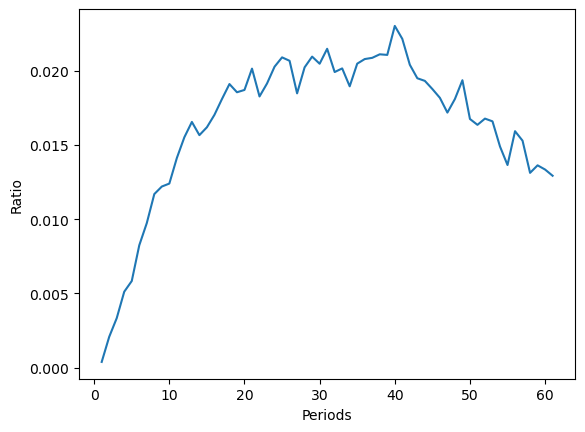

In [139]:
# 各周期数据的占比
period_stat_se = credit_join_df['PERIODS'].value_counts(normalize=True).sort_index()

plt.plot(period_stat_se)
plt.xlabel('Periods')
plt.ylabel('Ratio')

plt.show()

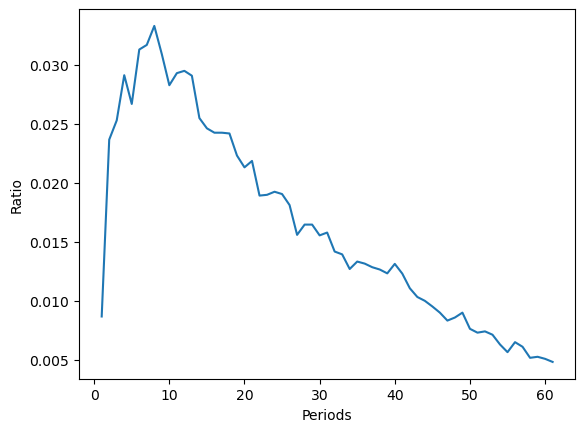

In [140]:
# 按客户分组的各周期数据占比
period_stat_se = credit_pivot_df['PERIODS'].value_counts(normalize=True).sort_index()

plt.plot(period_stat_se)
plt.xlabel('Periods')
plt.ylabel('Ratio')

plt.show()

In [141]:
period_stat_se.head(11).sum()

0.29816244427530714

#### TODO #2

In [142]:
# 观察窗口期太小的客户不参与分析
# 观察期的选择依赖于用户数据的厚薄程度。通常数据越厚，可提取的信息也就越全面、可靠
# 参考“风控特征—时间滑窗统计特征体系”（https://zhuanlan.zhihu.com/p/85440355）
# TODO
# 选择厚数据用户，筛选掉观察窗口小于等于10个月的用户数据
# 提示：直接提取出credit_join_df中周期大于10的即可
credit_filter_df = credit_join_df[credit_join_df['PERIODS']>10]
credit_filter_df.shape[0]

973441

In [143]:
credit_filter_df['ID'].nunique()

33599

In [144]:
credit_filter_df['STATUS'].value_counts()

STATUS
C    433513
0    335434
X    191676
1      9927
5      1577
2       803
3       301
4       210
Name: count, dtype: int64

#### 逾期调整  
只将逾期超过60天的算作逾期

#### TODO #3

In [145]:
# TODO
# 新增OVERDUE属性，判断逾期是否超过60天（要求：1代表超过60天，0代表不超过60天）
# 提示：可以根据STATUS属性进行操作（可以考虑用isin函数，结果需要转化为int值）
credit_filter_df['OVERDUE'] =credit_filter_df.STATUS.isin(['2','3','4','5']).astype("int")

C:\Users\Redamancy\AppData\Local\Temp\ipykernel_20632\116049454.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_filter_df['OVERDUE'] =credit_filter_df.STATUS.isin(['2','3','4','5']).astype("int")


In [146]:
credit_filter_df['OVERDUE'].value_counts()

OVERDUE
0    970550
1      2891
Name: count, dtype: int64

In [147]:
# 有历史逾期超过60天的客户数
credit_filter_df.loc[credit_filter_df['OVERDUE']==1, 'ID'].nunique()

598

In [148]:
# 查看某一个客户的历史逾期情况
credit_filter_df[credit_filter_df['ID']==5002126].sort_values(by='MONTHS_BALANCE', ascending=True)

,ID,MONTHS_BALANCE,STATUS,MIN_MONTH,MAX_MONTH,PERIODS,OVERDUE
8920,5002126,-55,0,-55,0,56,0
8919,5002126,-54,0,-55,0,56,0
8918,5002126,-53,X,-55,0,56,0
8917,5002126,-52,X,-55,0,56,0
8916,5002126,-51,1,-55,0,56,0
8915,5002126,-50,2,-55,0,56,1
8914,5002126,-49,2,-55,0,56,1
8913,5002126,-48,3,-55,0,56,1
8912,5002126,-47,3,-55,0,56,1
8911,5002126,-46,2,-55,0,56,1


#### 思考：  
上面这个客户在MOB5～9时发生逾期M3+，在进行Vintage分析时，对于这个客户在MOB10～55是否逾期应该如何考虑？

#### MOB构造  

In [149]:
# 计算每个账单的帐龄（通过数据探索，了解到首期账单逾期率较高，应属MOB1，而非MOB0）
credit_filter_df['MOB'] = credit_filter_df['MONTHS_BALANCE'] - credit_filter_df['MIN_MONTH'] + 1
credit_filter_df = credit_filter_df.sort_values(by = ['ID','MOB'])

C:\Users\Redamancy\AppData\Local\Temp\ipykernel_20632\1875475085.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_filter_df['MOB'] = credit_filter_df['MONTHS_BALANCE'] - credit_filter_df['MIN_MONTH'] + 1


In [150]:
credit_filter_df.head(10)

,ID,MONTHS_BALANCE,STATUS,MIN_MONTH,MAX_MONTH,PERIODS,OVERDUE,MOB
22,5001712,-18,0,-18,0,19,0,1
21,5001712,-17,0,-18,0,19,0,2
20,5001712,-16,0,-18,0,19,0,3
19,5001712,-15,0,-18,0,19,0,4
18,5001712,-14,0,-18,0,19,0,5
17,5001712,-13,0,-18,0,19,0,6
16,5001712,-12,0,-18,0,19,0,7
15,5001712,-11,0,-18,0,19,0,8
14,5001712,-10,0,-18,0,19,0,9
13,5001712,-9,0,-18,0,19,0,10


In [151]:
credit_filter_df.shape

(973441, 8)

### 4. 构造vintage

#### 逾期和总数

In [152]:
# 统计每个月的信贷订单数量，应该看的是MIN_MONTH，这里要去重，所以用之前按用户ID分组的pivot表
# 可以观察学习agg用法
denominator_df = credit_pivot_df.groupby(['MIN_MONTH']).agg({'ID': ['count']}) 
denominator_df.reset_index(inplace = True)
denominator_df.columns = ['MIN_MONTH', 'LENDING_COUNT']
denominator_df

,MIN_MONTH,LENDING_COUNT
0,-60,415
1,-59,406
2,-58,440
3,-57,400
4,-56,470
...,...,...
56,-4,874
57,-3,919
58,-2,771
59,-1,686


In [153]:
# 统计 每个月 x 每个MOB 的信贷订单数量
vintage_df = credit_filter_df.groupby(['MIN_MONTH','MOB']).agg({'ID': ['count']}) 
vintage_df = vintage_df.reset_index()
vintage_df.columns = ['MIN_MONTH','MOB','OVERDUE_RATIO'] 
vintage_df['OVERDUE_RATIO'] = np.nan
vintage_df.head(10)

,MIN_MONTH,MOB,OVERDUE_RATIO
0,-60,1,NaN
1,-60,2,NaN
2,-60,3,NaN
3,-60,4,NaN
4,-60,5,NaN
5,-60,6,NaN
6,-60,7,NaN
7,-60,8,NaN
8,-60,9,NaN
9,-60,10,NaN


In [154]:
# 补上缺失的MOB0数据行
lst = vintage_df["MIN_MONTH"].unique()
for i in lst:
    vintage_df = vintage_df._append({'MIN_MONTH': i, 'MOB': 0, 'OVERDUE_RATIO': np.nan}, ignore_index=True)
vintage_df = vintage_df.sort_values(by=['MIN_MONTH', 'MOB'])
vintage_df = vintage_df.reset_index(drop=True)
vintage_df

,MIN_MONTH,MOB,OVERDUE_RATIO
0,-60.0,0.0,NaN
1,-60.0,1.0,NaN
2,-60.0,2.0,NaN
3,-60.0,3.0,NaN
4,-60.0,4.0,NaN
...,...,...,...
1882,-10.0,7.0,NaN
1883,-10.0,8.0,NaN
1884,-10.0,9.0,NaN
1885,-10.0,10.0,NaN


#### TODO #4

In [155]:
# 合并，给每个MOB增加一列对应月份的信贷订单数量
# TODO
# 根据MIN_MONTH属性合并vintage_df, denominator_df（建议使用vintage_df的key）
# 提示： pd.merge函数
vintage_df = pd.merge(vintage_df,denominator_df,how="left",on="MIN_MONTH")

vintage_df = vintage_df.set_index(['MIN_MONTH', 'MOB'])
vintage_df

OVERDUE_RATIO  LENDING_COUNT
MIN_MONTH MOB                               
-60.0     0.0             NaN            415
          1.0             NaN            415
          2.0             NaN            415
          3.0             NaN            415
          4.0             NaN            415
...                       ...            ...
-10.0     7.0             NaN           1027
          8.0             NaN           1027
          9.0             NaN           1027
          10.0            NaN           1027
          11.0            NaN           1027

[1887 rows x 2 columns]

#### 去重后累加  
这里可以思考一下，为什么需要这么做？

In [156]:
# 一个人的逾期账单可以有多笔，只需保留首次逾期的记录，为什么？
overdue_credit_df = credit_filter_df[credit_filter_df['OVERDUE'] == 1]

In [157]:
# drop_duplicates拥有去重功能，可以学习一下
overdue_credit_df = overdue_credit_df.sort_values(by=['ID', 'MOB']).drop_duplicates(subset=['ID'], keep='first')
overdue_group_df = overdue_credit_df.groupby(['MIN_MONTH', 'MOB']).count()['ID']
overdue_group_df

MIN_MONTH  MOB
-60        6      1
           8      2
           10     1
           12     1
           13     1
                 ..
-10        7      2
           8      3
           9      2
           10     2
           11     1
Name: ID, Length: 437, dtype: int64

In [158]:
# 因为逾期率是一个累加的概念，比如10个月前的放款，看其在第10月的违约率，是要累计前几个月的违约个数的
# 会发现由于数据量少，在unstack的时候缺失了几个mob期，这个在cumsum也补不回来，如32 41 43等，需要手动添加

# unstack 从行到列取消堆叠
# 可以查询unstack和stack用法，下一个todo会用到，理解为主
unstack_overdue_df = overdue_group_df.unstack('MIN_MONTH').fillna(0)
unstack_overdue_df

MIN_MONTH,-60,-59,-58,-57,-56,-55,-54,-53,-52,-51,...,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10
MOB,,,,,,,,,,,,,,,,,,,,,
3,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,4.0,0.0,...,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0
4,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,1.0,1.0,2.0,1.0,0.0,1.0
5,0.0,0.0,0.0,0.0,2.0,3.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,1.0,0.0
6,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,3.0,...,2.0,0.0,1.0,1.0,1.0,3.0,0.0,0.0,2.0,1.0
7,0.0,1.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,1.0,...,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0
8,2.0,0.0,2.0,2.0,3.0,0.0,3.0,1.0,0.0,2.0,...,1.0,0.0,1.0,1.0,3.0,0.0,1.0,4.0,0.0,3.0
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0,2.0,2.0
10,1.0,2.0,0.0,0.0,2.0,1.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,3.0,2.0
11,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,0.0,2.0,0.0,1.0,1.0


In [159]:
# 补上缺失的MOB期数据行
for i in range(62):
    if i not in unstack_overdue_df.index:
        unstack_overdue_df.loc[i, :] = 0.0

#### TODO #5

In [160]:
unstack_overdue_df = unstack_overdue_df.sort_index()
# TODO
# 对unstack_overdue_df进行累计求和（查询资料cumsum函数）
cumsum_overdue_df = unstack_overdue_df.cumsum()

cumsum_overdue_df = cumsum_overdue_df.stack()
# 交换列顺序，可以了解一下
cumsum_overdue_df = cumsum_overdue_df.swaplevel()
cumsum_overdue_df

MIN_MONTH  MOB
-60        0       0.0
-59        0       0.0
-58        0       0.0
-57        0       0.0
-56        0       0.0
                  ... 
-14        61      9.0
-13        61     10.0
-12        61      7.0
-11        61     12.0
-10        61     13.0
Length: 3162, dtype: float64

#### TODO #6

In [161]:
# TODO
# vintage计算，分子/分母（思考一下逾期率是什么属性除以什么属性，两个属性均为上述计算得出）
# 提示：cumsum_overdue_df和vintage_df表
# 逾期订单数/总订单数
vintage_df['OVERDUE_RATIO'] = cumsum_overdue_df/vintage_df.LENDING_COUNT

In [162]:
vintage_df.reset_index()

,MIN_MONTH,MOB,OVERDUE_RATIO,LENDING_COUNT
0,-60.0,0.0,0.000000,415
1,-60.0,1.0,0.000000,415
2,-60.0,2.0,0.000000,415
3,-60.0,3.0,0.000000,415
4,-60.0,4.0,0.000000,415
...,...,...,...,...
1882,-10.0,7.0,0.004869,1027
1883,-10.0,8.0,0.007790,1027
1884,-10.0,9.0,0.009737,1027
1885,-10.0,10.0,0.011685,1027


#### 透视表

In [163]:
vintage_wide_df = vintage_df.reset_index().pivot(index = 'MIN_MONTH',
                             columns = 'MOB',
                             values = 'OVERDUE_RATIO')
vintage_wide_df

MOB,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0
MIN_MONTH,,,,,,,,,,,,,,,,,,,,,
-60.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.002410,0.002410,0.007229,0.007229,...,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.031325,0.031325,0.031325
-59.0,0.0,0.0,0.0,0.000000,0.002463,0.002463,0.002463,0.004926,0.004926,0.004926,...,0.027094,0.027094,0.027094,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,NaN
-58.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.004545,0.006818,...,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN
-57.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.005000,0.005000,...,0.022500,0.022500,0.022500,0.022500,0.022500,0.022500,0.022500,NaN,NaN,NaN
-56.0,0.0,0.0,0.0,0.004255,0.004255,0.008511,0.010638,0.010638,0.017021,0.017021,...,0.036170,0.036170,0.036170,0.036170,0.038298,0.038298,NaN,NaN,NaN,NaN
-55.0,0.0,0.0,0.0,0.002058,0.006173,0.012346,0.016461,0.022634,0.022634,0.022634,...,0.045267,0.045267,0.045267,0.045267,0.045267,NaN,NaN,NaN,NaN,NaN
-54.0,0.0,0.0,0.0,0.000000,0.002137,0.004274,0.004274,0.006410,0.012821,0.012821,...,0.032051,0.032051,0.032051,0.032051,NaN,NaN,NaN,NaN,NaN,NaN
-53.0,0.0,0.0,0.0,0.000000,0.000000,0.002028,0.002028,0.006085,0.008114,0.008114,...,0.026369,0.026369,0.026369,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-52.0,0.0,0.0,0.0,0.007233,0.009042,0.009042,0.009042,0.012658,0.012658,0.014467,...,0.023508,0.023508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 5. 画图展示

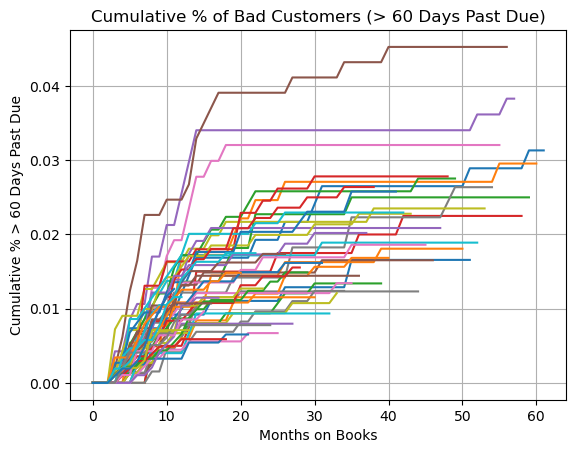

In [164]:
# plot vintage line chart
plt.rcParams['figure.facecolor'] = 'white'
vintage_wide_df.T.plot(legend = False, grid = True, title = 'Cumulative % of Bad Customers (> 60 Days Past Due)')
plt.xlabel('Months on Books')
plt.ylabel('Cumulative % > 60 Days Past Due')
plt.show()
